<a href="https://colab.research.google.com/github/Biruk-gebru/RNNTraining-/blob/main/RNNTask2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Download IMDB dataset
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

# Extract
!tar -xzf aclImdb_v1.tar.gz


--2025-06-25 10:33:56--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  48.3MB/s    in 1.7s    

2025-06-25 10:33:57 (48.3 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



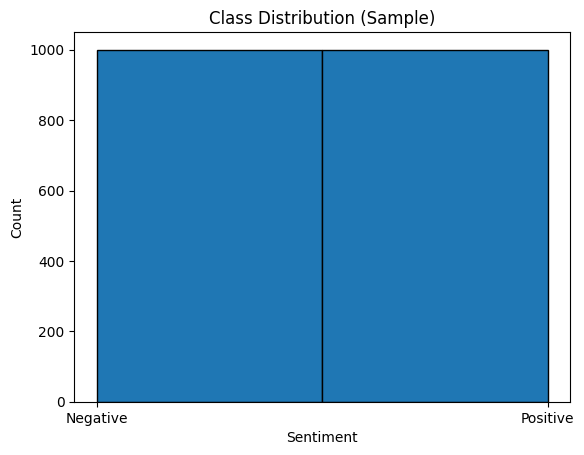


Label: Positive
I saw this movie at an advance screening and found it excellent.<br /><br />New York I Love You is a true spin on a romance that explores clever, funny, and sometimes shocking situations around the human race's most powerful emotion.<br /><br />The cast is huge, a veritable Oceans 11 with Andy Garcia, Ethan Hawke, Shia Labouf, Natalie Portman, Bradley Cooper and others. They all give stand out performances in one way or another.<br /><br />That's not to mention that there is a who's who of direc ...

Label: Positive
This is a very dark and intriguing horror type thriller based on the idea of religious murders. The storyline centres on a deranged man who lives in Texas, US who suddenly goes on a killing spree with his two young sons after being instructed by God to redeem the world of bad people.<br /><br />Bill Paxton who directs this movie plays the deranged Father who is known as the Hand of God Killer while Matthew McConaughey plays his finest performances to date a

In [33]:
import glob
import random
import matplotlib.pyplot as plt

def load_imdb_data(data_dir, split='train', sample_size=None):
    pos_files = glob.glob(f"{data_dir}/{split}/pos/*.txt")
    neg_files = glob.glob(f"{data_dir}/{split}/neg/*.txt")

    if sample_size:
        pos_files = random.sample(pos_files, sample_size // 2)
        neg_files = random.sample(neg_files, sample_size // 2)

    texts, labels = [], []

    for file in pos_files:
        with open(file, encoding='utf-8') as f:
            texts.append(f.read())
            labels.append(1)
    for file in neg_files:
        with open(file, encoding='utf-8') as f:
            texts.append(f.read())
            labels.append(0)

    return texts, labels

# Load a small sample for now
texts, labels = load_imdb_data("aclImdb", split='train', sample_size=2000)

# Visualize class distribution
plt.hist(labels, bins=2, edgecolor="black")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.title("Class Distribution (Sample)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Show random examples
for i in range(3):
    print(f"\nLabel: {'Positive' if labels[i] == 1 else 'Negative'}")
    print(texts[i][:500], "...")


In [34]:
import torch
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

# Token generator
def yield_tokens(texts):
    for text in texts:
        yield tokenizer(text)

# Build vocab
vocab = build_vocab_from_iterator(yield_tokens(texts), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])


In [35]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(text)
        token_ids = [self.vocab[token] for token in tokens]
        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(label, dtype=torch.float)


In [36]:
def collate_batch(batch):
    text_batch, label_batch = [], []
    for text, label in batch:
        text_batch.append(text)
        label_batch.append(label)

    text_batch = pad_sequence(text_batch, batch_first=True, padding_value=vocab["<pad>"])
    label_batch = torch.stack(label_batch)
    return text_batch, label_batch

# Create dataset and dataloader
train_dataset = IMDBDataset(texts, labels, vocab, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)


In [37]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])  # use final hidden state
        return out.squeeze()       # raw logits, not sigmoid


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SentimentRNN(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=128,
    output_dim=1
).to(device)

# Balance the dataset
pos_count = sum(labels)
neg_count = len(labels) - pos_count
pos_weight = torch.tensor([neg_count / pos_count]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [40]:
def train(model, dataloader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")
train(model, train_loader, epochs=5)


Epoch 1, Loss: 0.6948
Epoch 2, Loss: 0.6928
Epoch 3, Loss: 0.6908
Epoch 4, Loss: 0.6895
Epoch 5, Loss: 0.6854


Accuracy: 0.5115
Precision: 0.5059
Recall: 0.9910
F1 Score: 0.6698


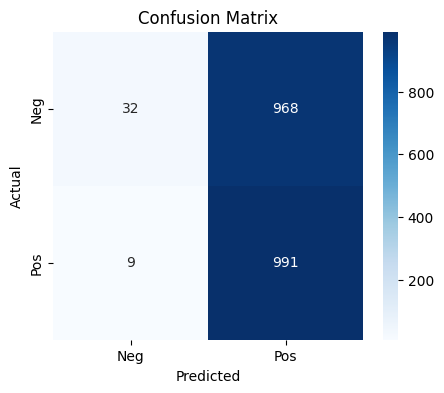

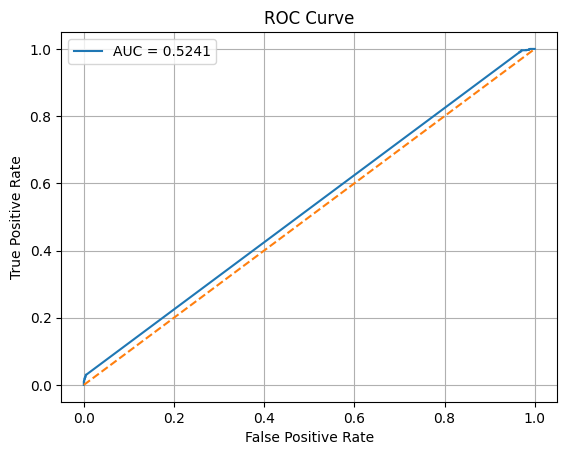

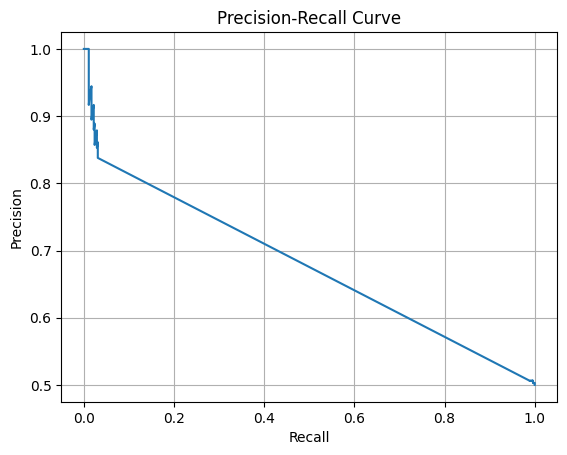

In [41]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, dataloader):
    model.eval()
    preds, probs, truths = [], [], []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts = texts.to(device)
            logits = model(texts).cpu()
            probs_batch = torch.sigmoid(logits)
            preds_batch = (probs_batch > 0.5).int()

            probs.extend(probs_batch.tolist())
            preds.extend(preds_batch.tolist())
            truths.extend(labels.tolist())

    acc = accuracy_score(truths, preds)
    prec = precision_score(truths, preds, zero_division=0)
    rec = recall_score(truths, preds, zero_division=0)
    f1 = f1_score(truths, preds, zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion matrix plot
    cm = confusion_matrix(truths, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(truths, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall curve
    precisions, recalls, _ = precision_recall_curve(truths, probs)
    plt.figure()
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.show()
evaluate(model, train_loader)  # or test_loader if you prepared test data


In [42]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), "/content/drive/MyDrive/sentiment_rnn.pth")
print("Model saved to Google Drive.")


Mounted at /content/drive
Model saved to Google Drive.
